In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'face-mask-12k-images-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F675484%2F1187790%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240912%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240912T162000Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Daf461ffd96dd3eaac7d3b6414420a862812c3fa07aba7f8188350acfba993731876921b7a0e4f91323042e55ce7097a7b81d0d8b79b8c84c9bfab0e4610b3dbc25da1e27b96ecab7475262296726d2b0a3951d8c769484f31eba7efb3d6530c3d3c9ba580582c213ec2439e9b45c65b75e5fde559b6f0dd66bf132c966cc52617b0f0728ad4f6d74f3f582b425417b1d72e9f150023ec415e775534eb8464f09553e66f7cf19203b95d996480f3050ab3208945375ef71bcc7cd15043c1d392d6727484bb634553bcf4c7fcc6d0cab54f32667377f7362fc805823e1338adaa921b2d0a31cfe59288bda5755f8187be5cda5d47d51416f82731e2e910c5fc5b5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# About Dataset
Context
This dataset is used for Face Mask Detection Classification with images. The dataset consists of almost 12K images which are almost 328.92MB in size.

Acknowledgments
All the images with the face mask (~6K) are scrapped from google search and all the images without the face mask are preprocessed from the CelebFace dataset created by Jessica Li (https://www.kaggle.com/jessicali9530). Thank you so much Jessica for providing a wonderful dataset to the community.

Inspiration
The inspiration behind creating this dataset is to create an algorithm that can directly detect is a person is wearing a face mask or not. So I've scrapped the images from google as well as from the CelebFace dataset created by Jessica Li (https://www.kaggle.com/jessicali9530) to make this happen.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import models,layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile

In [ ]:
T_f=ImageDataGenerator(
rescale=1./255,
horizontal_flip=True,
rotation_range=20,
zoom_range=0.2,
shear_range=0.2,
vertical_flip=True
)
Train=T_f.flow_from_directory(
"/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train",
    target_size=(224,224),
batch_size=32,
class_mode="sparse")

Found 10000 images belonging to 2 classes.


In [ ]:
Vaild = ImageDataGenerator(rescale = 1/255 )

# تحميل بيانات التدريب من المجلد
vaild = Vaild.flow_from_directory(
    "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation",       # خطوة 4
    target_size=(224, 224),     # خطوة 5
    batch_size=32,              # خطوة 6
    class_mode= 'sparse')      #

Found 800 images belonging to 2 classes.


In [ ]:
test = Vaild.flow_from_directory(
    "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test",       # خطوة 4
    target_size=(224, 224),     # خطوة 5
    batch_size=32,              # خطوة 6
    class_mode= 'sparse')      #

Found 992 images belonging to 2 classes.


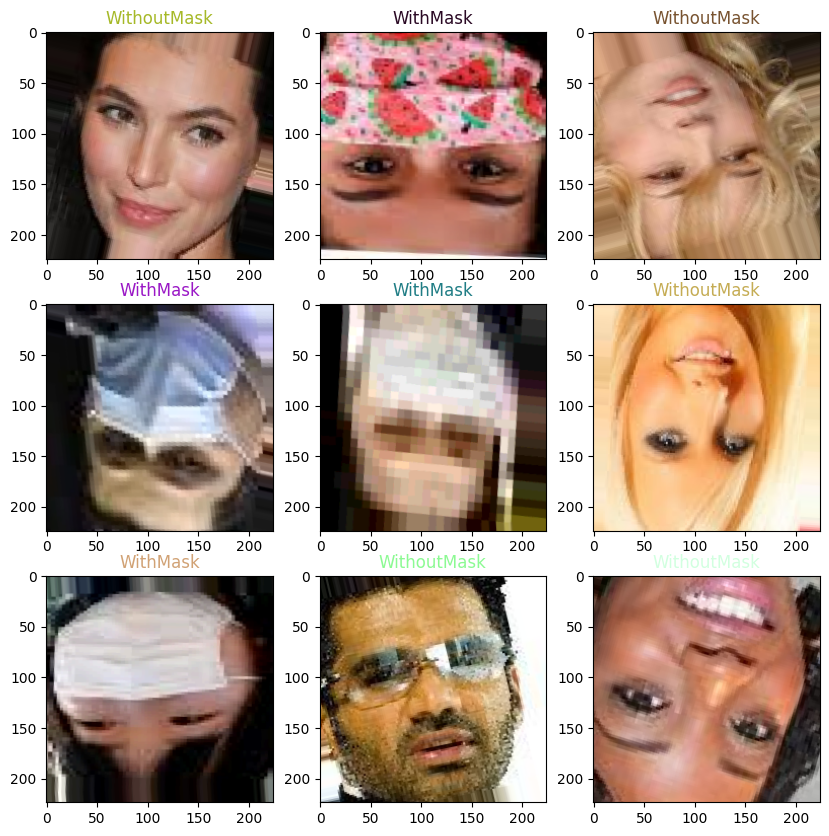

In [ ]:
# استخراج الفئات
gen_dict = Train.class_indices
classes = list(gen_dict.keys())

# جلب الصور والتسميات من المولد
images, labels = next(Train)

# ضبط حجم الصور (بما أن target_size=(244,244))
image_height, image_width = 224, 224

# إعداد نافذة الرسم
plt.figure(figsize=(10, 10))

# عرض 9 صور عشوائية
random_indices = np.random.choice(len(images), 9, replace=False)  # اختيار 9 صور عشوائية

for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)

    # اختيار الصورة وحجمها
    image = images[idx]  # الصورة تأتي بالفعل بحجم 244x244x3

    # عرض الصورة
    plt.imshow(image)

    # اختيار الفئة (لا حاجة لـ np.argmax لأن labels أرقام صحيحة)
    class_name = classes[int(labels[idx])]

    # تعيين لون عشوائي للعنوان
    random_color = np.random.rand(3,)  # اختيار لون عشوائي (RGB)

    # تعيين العنوان للفئة
    plt.title(class_name, color=random_color, fontsize=12)

# عرض الرسم
plt.show()

In [ ]:
train_image, train_label = next(Train)
print(train_image.shape)  # Should be (batch_size, height, width, channels)
print(train_label.shape)  # Should be (batch_size,)

(32, 224, 224, 3)
(32,)


 # **Convolutional Neural Network (NASNetMobile)**

In [ ]:
FaceMask=NASNetMobile (weights="imagenet",include_top=False,input_shape=(224,224,3))
x=GlobalAveragePooling2D()(FaceMask.output)
x=Dense(128,activation="relu")(x)
output_layer=Dense(38,activation="softmax")(x)

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model=Model(inputs=FaceMask.input,outputs=output_layer)

In [ ]:
for layer in FaceMask.layers:
    layer.trainable=False

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │        352 │ activation[0][0]  │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │        396 │ activation_2[0][

 Total params: 4,409,914 (16.82 MB)

 Trainable params: 140,198 (547.65 KB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [ ]:
# تجميع النموذج
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,  # Number of epochs to wait for improvement
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(Train, validation_data=vaild, epochs=15, callbacks=[early_stopping])


Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726154572.917326     128 service.cc:145] XLA service 0x7aa77404da50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726154572.917388     128 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/313 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.1875 - loss: 3.3270       

I0000 00:00:1726154585.331248     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 256s 685ms/step - accuracy: 0.9331 - loss: 0.2456 - val_accuracy: 0.9889 - val_loss: 0.0199
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 134s 419ms/step - accuracy: 0.9816 - loss: 0.0567 - val_accuracy: 0.9899 - val_loss: 0.0250
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 435ms/step - accuracy: 0.9838 - loss: 0.0465 - val_accuracy: 0.9960 - val_loss: 0.0150
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 430ms/step - accuracy: 0.9854 - loss: 0.0397 - val_accuracy: 0.9940 - val_loss: 0.0177
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 433ms/step - accuracy: 0.9889 - loss: 0.0319 - val_accuracy: 0.9940 - val_loss: 0.0156
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 428ms/step - accuracy: 0.9881 - loss: 0.0326 - val_accuracy: 0.9909 - val_loss: 0.0236
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 421ms/step - accuracy: 0.9879 - loss: 0.0362 - val_accuracy: 0.9929 - val_loss: 0.0210
Epoch 9/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 134s 418ms/step - accuracy: 0.9860 - loss: 0.03

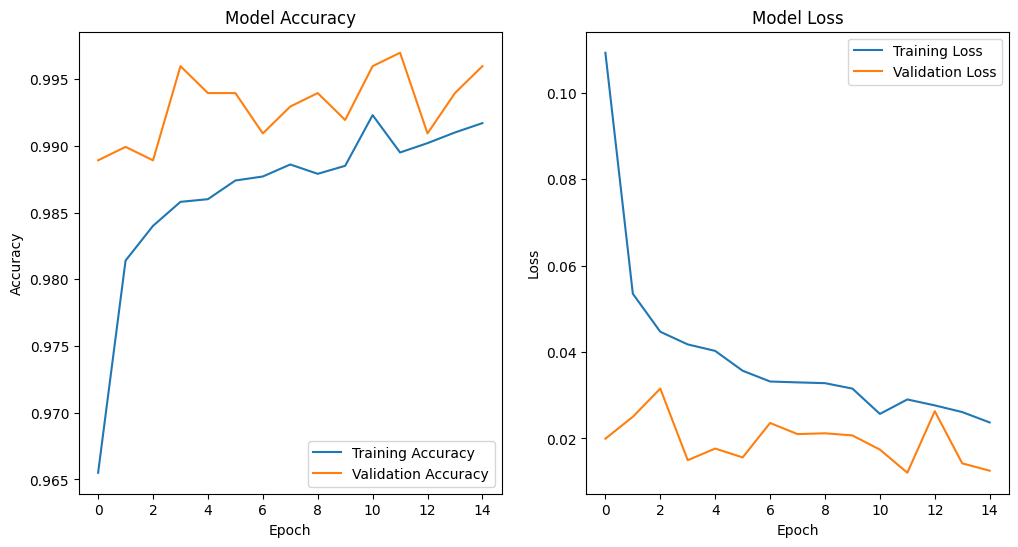

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# رسم دقة التدريب والتحقق
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# رسم خسارة التدريب والتحقق
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9978 - loss: 0.0098
Test Loss: 0.012070983648300171, Test Accuracy: 0.9969757795333862


In [ ]:
# لتقييم النموذج على مجموعة بيانات التحقق
val_loss, val_accuracy = model.evaluate(vaild)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9963 - loss: 0.0147
Validation Loss: 0.012070982716977596, Validation Accuracy: 0.9969757795333862


In [ ]:
class_names = list(Train.class_indices.keys())
class_names

['WithMask', 'WithoutMask']

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


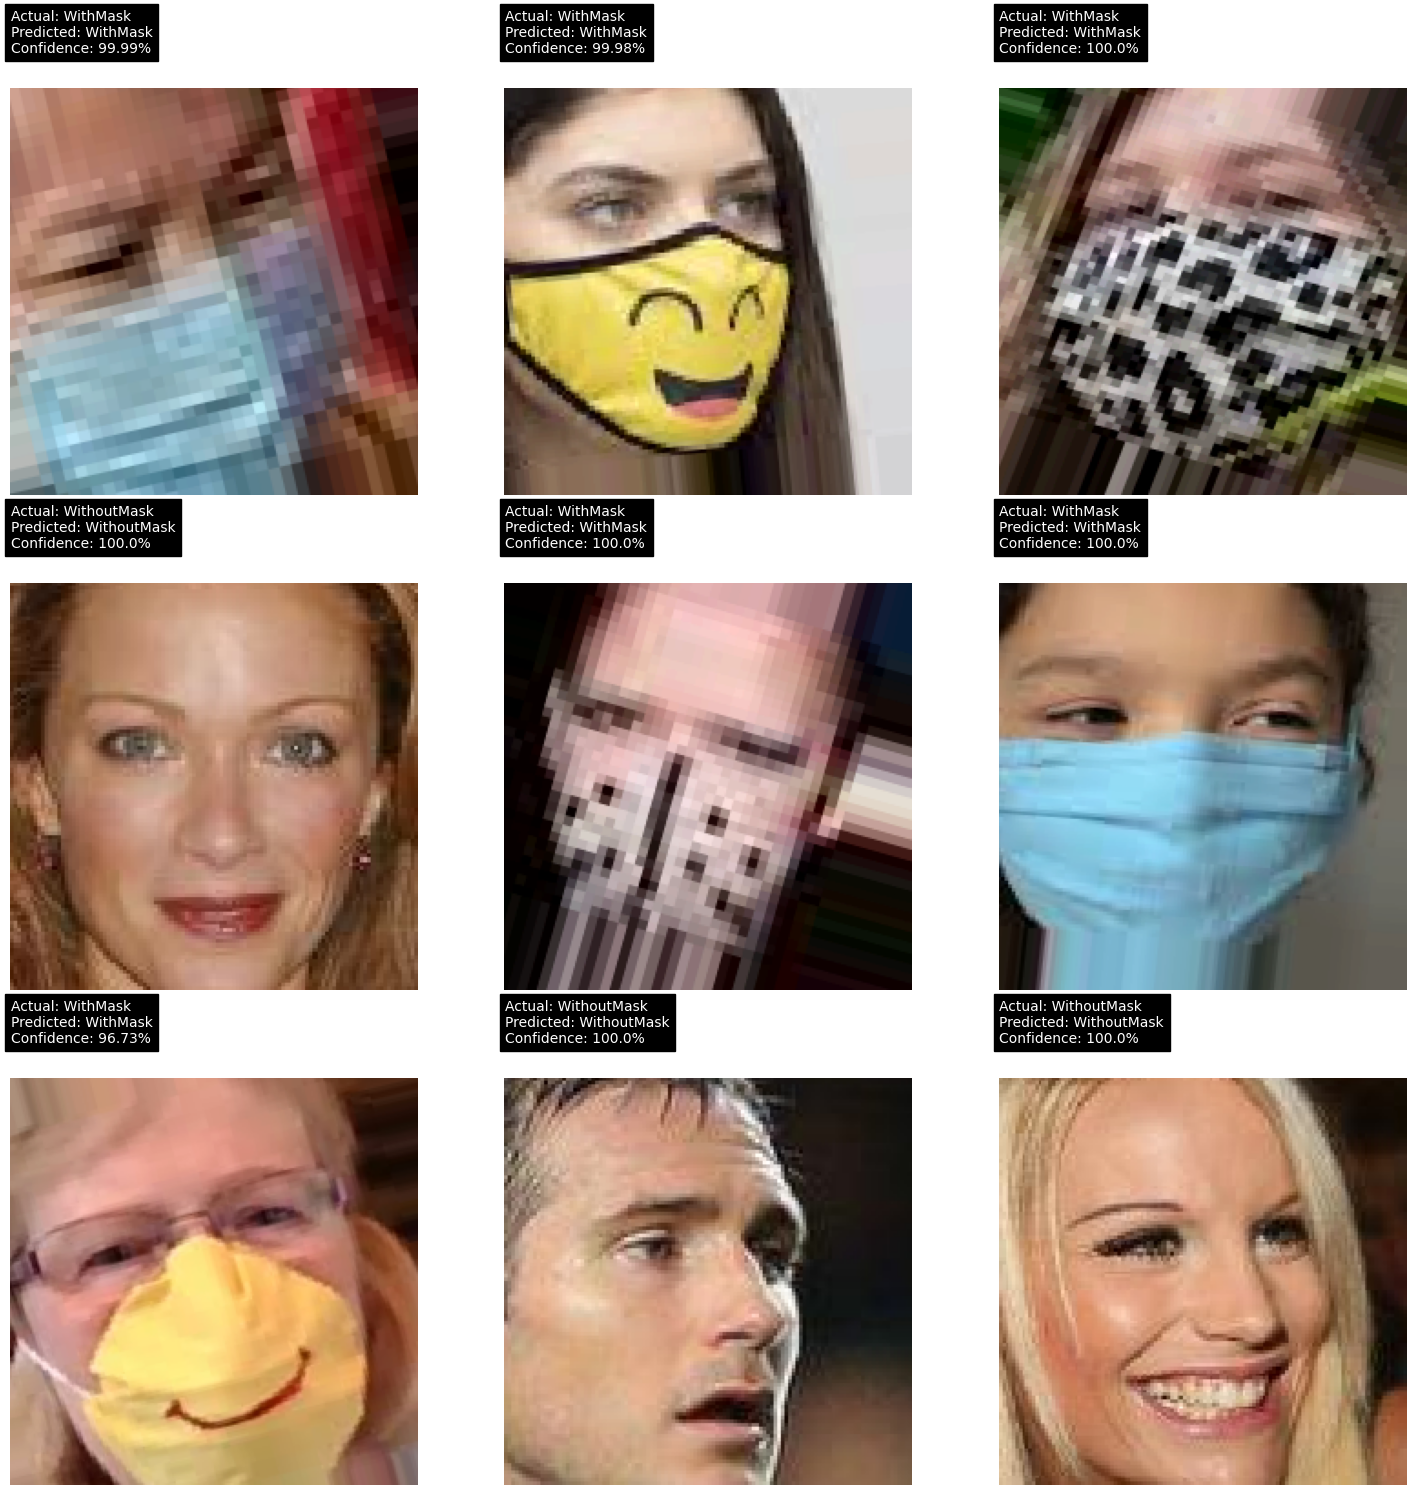

In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in test:
    for i in range(min(9, len(images))):  # تحقق من أن عدد الصور لا يتجاوز 9
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis("off")

        # قم بالتنبؤ بالصورة
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])]

        # قم بإعداد النص المعلوماتي
        text = f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%"

        # إضافة النص إلى الصورة
        plt.text(0, -20, text, color='white', fontsize=10, ha='left', backgroundcolor='black')

    # اكتمل العرض للصور، فقط استمر إذا كانت هناك مزيد من الصور للعرض
    break

plt.tight_layout()  # ضبط التخطيط
plt.show()  # عرض الشكل


In [ ]:
# # Save the entire model as a `.keras` zip archive
model.save('FaceMask.h5')

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# تحميل النموذج المدرب
model = load_model('/kaggle/working/FaceMask.h5')

# إعداد الفئات
class_names = ['Without Mask', 'With Mask']

# تحميل نموذج OpenCV لاكتشاف الوجه
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# فتح الكاميرا
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()

    # اكتشاف الوجوه في الإطار
    faces = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=4)

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (224, 224))  # تعديل الحجم ليتناسب مع نموذجك
        face_normalized = face_resized / 255.0
        face_input = np.expand_dims(face_normalized, axis=0)

        # تنبؤ إذا كان الشخص يرتدي قناعًا أم لا
        prediction = model.predict(face_input)
        class_idx = np.argmax(prediction)
        class_name = class_names[class_idx]

        # عرض النتيجة على الإطار
        color = (0, 255, 0) if class_name == 'With Mask' else (0, 0, 255)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, class_name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    cv2.imshow('Face Mask Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


[ WARN:0@5.777] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@5.778] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:973: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


In [ ]:
import cv2

# فتح الكاميرا
cap = cv2.VideoCapture(0)  # أو الرقم الصحيح للكاميرا الخاصة بك

while True:
    ret, frame = cap.read()

    # تحقق من نجاح قراءة الإطار
    if not ret:
        print("فشل في التقاط الإطار")
        break

    # تنفيذ عمليات التعرف أو المعالجة هنا

    # عرض الإطار
    cv2.imshow('Face Mask Detection', frame)

    # إنهاء العرض عند الضغط على 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# تحرير الكاميرا وإغلاق النوافذ
cap.release()
cv2.destroyAllWindows()


فشل في التقاط الإطار


[ WARN:0@70.254] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@70.254] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
